# %% [markdown]

 Installing required libraries
 !pip install matplotlib tqdm

# %% [markdown]

## 1. Importing required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# import torchvision
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# %% [markdown]

 Check version of torch and torchvision

In [ ]:
print(f"Torch version: {torch.__version__}")
# print(f"Torchvision version: {torchvision.__version__}")

Torch version: 2.1.0+cu118


# %% [markdown]

## 2. Setting up the device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# %% [markdown]

## 3. Set the seed

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

# %% [markdown]

## 4. Setting up the hyperparameters

In [ ]:
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

# %% [markdown]

## 5. Define the data transformation

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

# %% [markdown]

## 6. Load the dataset

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# %% [markdown]

## 7. Load the dataset

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# %% [markdown]

## 8. Check the shape of the dataset

In [ ]:
print(f"Total Train dataset batches: {len(train_loader)} and each batch size: {BATCH_SIZE}")
print(f"Total Test dataset batches: {len(test_loader)} and each batch size: {BATCH_SIZE}")

Total Train dataset batches: 391 and each batch size: 128
Total Test dataset batches: 79 and each batch size: 128


# %% [markdown]

## 9. Building the Vision Transformer model

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
            )
        self.num_patches = (image_size // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x: torch.Tensor):
        B = x.size(0)
        x = self.proj(x) # (B, embed_dim, H, W)
        x = x.flatten(2) # (B, embed_dim, H*W)
        x = x.transpose(1, 2) # (B, H*W, embed_dim)
        cls_token = self.cls_token.expand(B, -1, -1) # (B, 1, embed_dim)
        x = torch.cat([cls_token, x], dim=1) # (B, 1 + H*W, embed_dim)
        x = x + self.pos_embed # (B, 1 + H*W, embed_dim)
        return x

# %% [markdown]

## 10. MLP Block

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, drop_rate=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, x: torch.Tensor):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

# %% [markdown]

## 11. Transformer Encoder

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x: torch.Tensor):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

# %% [markdown]

## 12. Vision Transformer

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, num_heads, mlp_dim, depth, drop_rate=0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.transformer_encoder = nn.Sequential(*[
            TransformerEncoder(embed_dim, num_heads, mlp_dim, drop_rate) 
            for _ in range(depth)
            ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x: torch.Tensor):
        x = self.patch_embedding(x)
        x = self.transformer_encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0]
        x = self.head(cls_token)
        return x

# %% [markdown]

## 13. Initialize the model

In [ ]:
model = VisionTransformer(
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=CHANNELS,
    num_classes=NUM_CLASSES,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM,
    depth=DEPTH,
    drop_rate=DROP_RATE
    ).to(device)

# %% [markdown]

## 14. Print the model summary

In [ ]:
print(model)
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoder(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp

# %% [markdown]

## 15. Define the optimizer and the loss function

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# %% [markdown]

## 16. Define the training loop

In [ ]:
def train_model(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    for (data, target) in train_loader:
        # 1. Move the data to the device
        data, target = data.to(device), target.to(device) # (B, 3, 32, 32)
        # 2. Zero the gradients
        optimizer.zero_grad()
        # 3. Forward pass
        output = model(data)
        # 4. Calculate the loss
        loss = criterion(output, target)
        # 5. Backward pass
        loss.backward()
        # 6. Update the weights
        optimizer.step()
        # 7. Update the loss
        total_loss += loss.item() * data.size(0) # (B, 3, 32, 32)
        # 8. Update the accuracy
        correct += (output.argmax(dim=1) == target).sum().item()
    # 11. Return the loss and the accuracy
    return total_loss / len(train_loader.dataset), correct / len(train_loader.dataset)

# %% [markdown]

## 17. Define the validation loop

In [ ]:
def validate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.inference_mode():
        for (data, target) in test_loader:
            # 1. Move the data to the device
            data, target = data.to(device), target.to(device) # (B, 3, 32, 32)
            # 2. Forward pass
            output = model(data)
            # 3. Calculate the loss
            loss = criterion(output, target)
            # 4. Update the loss
            total_loss += loss.item() * data.size(0) # (B, 3, 32, 32)
            # 5. Update the accuracy
            correct += (output.argmax(dim=1) == target).sum().item()
    # 8. Return the loss and the accuracy
    return total_loss / len(test_loader.dataset), correct / len(test_loader.dataset)

# %% [markdown]

## 18. Train the model

In [ ]:
best_loss = float('inf')
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
for epoch in tqdm(range(EPOCHS), desc="Training"):
    train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion, device, epoch)
    test_loss, test_accuracy = validate_model(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss {train_loss:.4f} | Train Accuracy {train_accuracy:.4f}% | Test Loss {test_loss:.4f} | Test Accuracy {test_accuracy:.4f}%")
    # save the checkpoint if the validation loss is the lowest
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "vision_transformer_best_model.pth")

Training:   3%|▎         | 1/30 [00:54<26:19, 54.45s/it]

Epoch 0/30 | Train Loss 1.9265 | Train Accuracy 0.2911% | Test Loss 1.7278 | Test Accuracy 0.3781%


Training:   7%|▋         | 2/30 [01:48<25:25, 54.49s/it]

Epoch 1/30 | Train Loss 1.6659 | Train Accuracy 0.3953% | Test Loss 1.5668 | Test Accuracy 0.4349%


Training:  10%|█         | 3/30 [02:43<24:32, 54.53s/it]

Epoch 2/30 | Train Loss 1.5615 | Train Accuracy 0.4371% | Test Loss 1.5181 | Test Accuracy 0.4496%


Training:  13%|█▎        | 4/30 [03:38<23:37, 54.51s/it]

Epoch 3/30 | Train Loss 1.4870 | Train Accuracy 0.4630% | Test Loss 1.4317 | Test Accuracy 0.4846%


Training:  17%|█▋        | 5/30 [04:32<22:40, 54.44s/it]

Epoch 4/30 | Train Loss 1.4274 | Train Accuracy 0.4856% | Test Loss 1.3949 | Test Accuracy 0.5014%


Training:  20%|██        | 6/30 [05:26<21:45, 54.38s/it]

Epoch 5/30 | Train Loss 1.3773 | Train Accuracy 0.5052% | Test Loss 1.3483 | Test Accuracy 0.5118%


Training:  23%|██▎       | 7/30 [06:21<20:51, 54.40s/it]

Epoch 6/30 | Train Loss 1.3331 | Train Accuracy 0.5213% | Test Loss 1.2844 | Test Accuracy 0.5403%


Training:  27%|██▋       | 8/30 [07:15<19:56, 54.39s/it]

Epoch 7/30 | Train Loss 1.2934 | Train Accuracy 0.5361% | Test Loss 1.2606 | Test Accuracy 0.5474%


Training:  30%|███       | 9/30 [08:09<19:01, 54.34s/it]

Epoch 8/30 | Train Loss 1.2558 | Train Accuracy 0.5501% | Test Loss 1.2328 | Test Accuracy 0.5588%


Training:  33%|███▎      | 10/30 [09:03<18:06, 54.30s/it]

Epoch 9/30 | Train Loss 1.2197 | Train Accuracy 0.5638% | Test Loss 1.2063 | Test Accuracy 0.5641%


Training:  37%|███▋      | 11/30 [09:57<17:08, 54.15s/it]

Epoch 10/30 | Train Loss 1.1846 | Train Accuracy 0.5798% | Test Loss 1.1549 | Test Accuracy 0.5825%


Training:  40%|████      | 12/30 [10:51<16:13, 54.08s/it]

Epoch 11/30 | Train Loss 1.1512 | Train Accuracy 0.5875% | Test Loss 1.1750 | Test Accuracy 0.5784%


Training:  43%|████▎     | 13/30 [11:45<15:17, 53.98s/it]

Epoch 12/30 | Train Loss 1.1198 | Train Accuracy 0.5980% | Test Loss 1.1041 | Test Accuracy 0.6064%


Training:  47%|████▋     | 14/30 [12:39<14:23, 53.95s/it]

Epoch 13/30 | Train Loss 1.0928 | Train Accuracy 0.6099% | Test Loss 1.0706 | Test Accuracy 0.6148%


Training:  50%|█████     | 15/30 [13:33<13:29, 53.95s/it]

Epoch 14/30 | Train Loss 1.0643 | Train Accuracy 0.6202% | Test Loss 1.0858 | Test Accuracy 0.6200%


Training:  53%|█████▎    | 16/30 [14:27<12:35, 53.98s/it]

Epoch 15/30 | Train Loss 1.0432 | Train Accuracy 0.6304% | Test Loss 1.0511 | Test Accuracy 0.6262%


Training:  57%|█████▋    | 17/30 [15:21<11:41, 53.98s/it]

Epoch 16/30 | Train Loss 1.0175 | Train Accuracy 0.6382% | Test Loss 1.0381 | Test Accuracy 0.6269%


Training:  60%|██████    | 18/30 [16:15<10:47, 53.97s/it]

Epoch 17/30 | Train Loss 0.9971 | Train Accuracy 0.6441% | Test Loss 1.0313 | Test Accuracy 0.6370%


Training:  63%|██████▎   | 19/30 [17:08<09:53, 53.92s/it]

Epoch 18/30 | Train Loss 0.9793 | Train Accuracy 0.6523% | Test Loss 0.9829 | Test Accuracy 0.6449%


Training:  67%|██████▋   | 20/30 [18:03<08:59, 53.97s/it]

Epoch 19/30 | Train Loss 0.9518 | Train Accuracy 0.6614% | Test Loss 1.0021 | Test Accuracy 0.6437%


Training:  70%|███████   | 21/30 [18:57<08:06, 54.03s/it]

Epoch 20/30 | Train Loss 0.9353 | Train Accuracy 0.6714% | Test Loss 0.9870 | Test Accuracy 0.6512%


Training:  73%|███████▎  | 22/30 [19:51<07:11, 53.98s/it]

Epoch 21/30 | Train Loss 0.9259 | Train Accuracy 0.6721% | Test Loss 0.9571 | Test Accuracy 0.6643%


Training:  77%|███████▋  | 23/30 [20:45<06:18, 54.00s/it]

Epoch 22/30 | Train Loss 0.9018 | Train Accuracy 0.6780% | Test Loss 0.9403 | Test Accuracy 0.6730%


Training:  80%|████████  | 24/30 [21:38<05:23, 53.92s/it]

Epoch 23/30 | Train Loss 0.8867 | Train Accuracy 0.6847% | Test Loss 0.9420 | Test Accuracy 0.6718%


Training:  83%|████████▎ | 25/30 [22:32<04:29, 53.94s/it]

Epoch 24/30 | Train Loss 0.8725 | Train Accuracy 0.6908% | Test Loss 0.9275 | Test Accuracy 0.6709%


Training:  87%|████████▋ | 26/30 [23:27<03:36, 54.04s/it]

Epoch 25/30 | Train Loss 0.8522 | Train Accuracy 0.6954% | Test Loss 0.8906 | Test Accuracy 0.6830%


Training:  90%|█████████ | 27/30 [24:22<02:42, 54.30s/it]

Epoch 26/30 | Train Loss 0.8383 | Train Accuracy 0.7010% | Test Loss 0.9222 | Test Accuracy 0.6783%


Training:  93%|█████████▎| 28/30 [25:16<01:48, 54.46s/it]

Epoch 27/30 | Train Loss 0.8182 | Train Accuracy 0.7078% | Test Loss 0.8940 | Test Accuracy 0.6876%


Training:  97%|█████████▋| 29/30 [26:11<00:54, 54.51s/it]

Epoch 28/30 | Train Loss 0.8026 | Train Accuracy 0.7165% | Test Loss 0.8791 | Test Accuracy 0.6932%


Training: 100%|██████████| 30/30 [27:05<00:00, 54.18s/it]

Epoch 29/30 | Train Loss 0.7853 | Train Accuracy 0.7197% | Test Loss 0.8779 | Test Accuracy 0.6913%


# %% [markdown]

## 19. Load the best model

In [ ]:
model.load_state_dict(torch.load("vision_transformer_best_model.pth"))

<All keys matched successfully>

# %% [markdown]

## 20. Plot the training and validation accuracy with loss in two subplots in vertical format

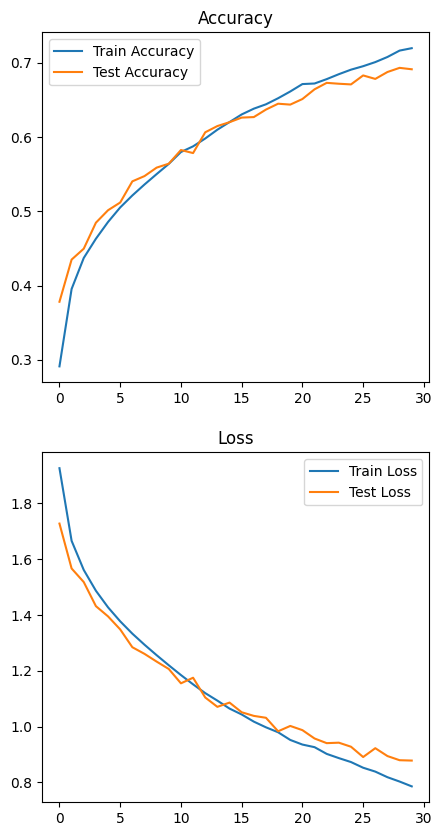

In [ ]:
plt.figure(figsize=(5, 10))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Accuracy")   
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss")
plt.legend()
plt.show()

# %% [markdown]

## 21. Predict and plot the grid of random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input dat

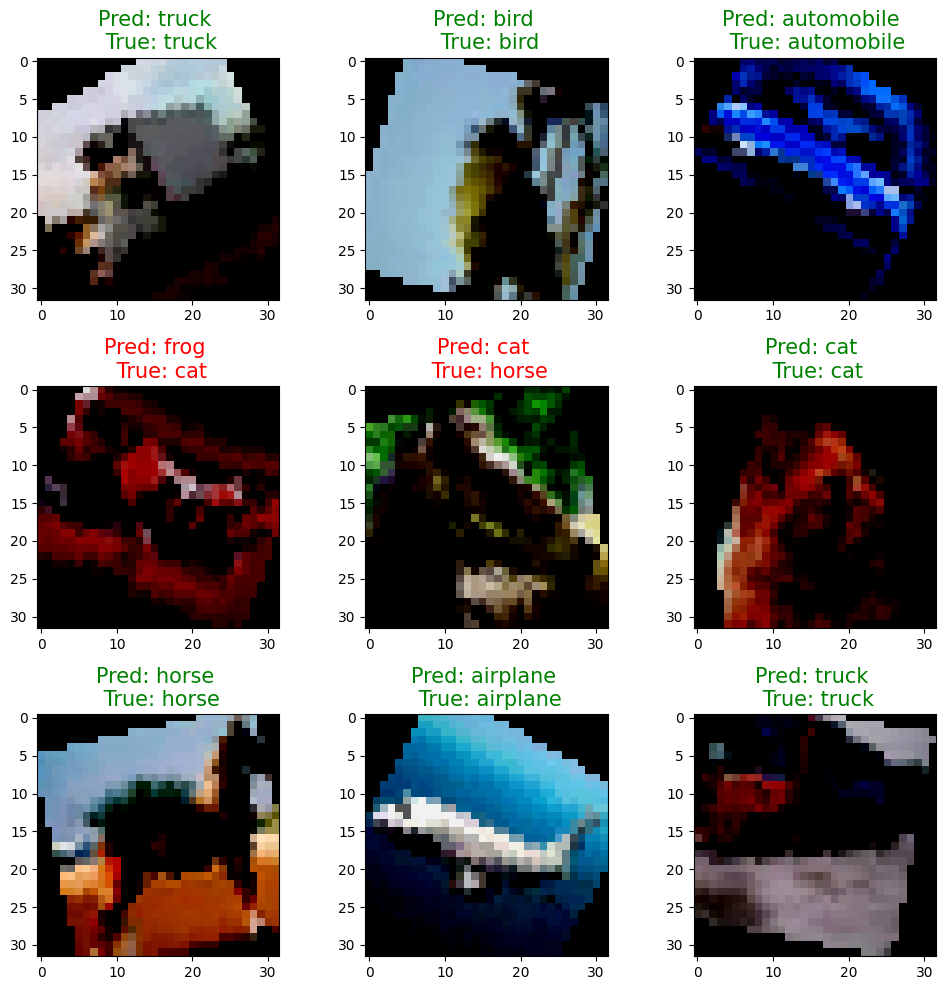

In [ ]:
def predict_and_plot_grid(model, dataset, classes, num_images=9, max_rows=3, fontsize=8):
    model.eval()
    with torch.inference_mode():
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            img, label = random.choice(dataset)
            output = model(img.unsqueeze(0).to(device))
            pred_label = classes[output.argmax(dim=1)]
            plt.subplot(max_rows, num_images // max_rows, i + 1)
            plt.imshow(img.permute(1, 2, 0))
            plt.title(f"Pred: {pred_label} \n True: {classes[label]}", fontsize=fontsize, color="green" if pred_label == classes[label] else "red")
    plt.tight_layout()
    plt.show()
    
predict_and_plot_grid(model, test_dataset, test_dataset.classes, num_images=9, fontsize=15)